In [1]:
from PIL import Image
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from einops import rearrange, einsum

In [2]:
from patched_clip.patched_clip import CLIP_args, get_clip_embeddings, load_clip, save_clip_embeddings

In [3]:
from patched_clip import modified_clip

In [4]:
model, preprocess = load_clip()

In [5]:
image_paths = ['test.jpg']
device = 'cpu'

In [6]:
# CLIP_args.clip_model_name = CLIPArgs.model_type
# CLIP_args.device = device
high_res_feature = True

# Load images into pillow images
images = [Image.open(image_path) for image_path in image_paths]

# Get CLIP embeddings
with torch.no_grad():
    descriptors = get_clip_embeddings(images, to_cpu=False, skip_center_crop=high_res_feature)
    descriptors = descriptors.to(device)  # BCHW

ML_LOGGER_USER is not set. This is required for online usage.
timing <load_clip_model>: 4.542E+00s
timing <clip_preprocess_images>: 2.052E-01s
timing <get_clip_embeddings>: 1.016E+00s
clip_process_image_mean_time: 1.2222929580020718


In [7]:
patch_features_bchw = descriptors / descriptors.norm(dim=1, keepdim=True)

In [8]:
# text
text_inputs = torch.cat([modified_clip.tokenize(f"a photo of a {c}") for c in ['chair', 'computer monitor', 'background']]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=1, keepdim=True)

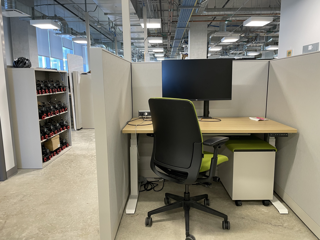

In [9]:
images[0].resize((320, 240))

In [10]:
similarity_mat_bhwc = rearrange(patch_features_bchw, 'b c h w-> b h w c') @ text_features.T
similarity_mat_bhwc = similarity_mat_bhwc.softmax(dim=3)
print(similarity_mat_bhwc.shape)

torch.Size([1, 24, 32, 3])


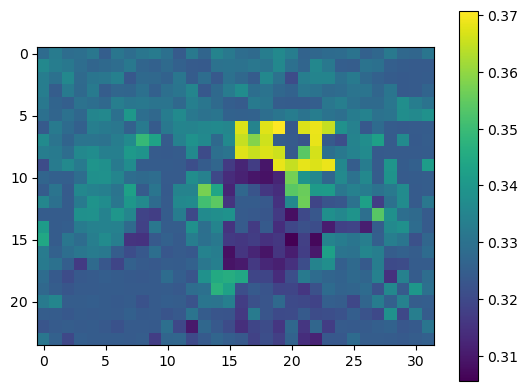

In [11]:
heatmap = similarity_mat_bhwc[0, :, :, 1].numpy()
plt.imshow(heatmap)
plt.colorbar()